# Parkinson Disease Detection

Comprehensive machine learning project to detect Parkinson's disease from voice signal features.

## Project Overview
- **Goal**: Predict whether a patient has Parkinson's disease using voice/acoustic measurements.
- **Input**: 22+ numerical voice features (jitter, shimmer, fundamental frequency, HNR, RPDE, DFA, PPE, etc.).
- **Target**: `status` (0 = healthy, 1 = Parkinson's).

## Pipeline
1. **Data Loading** – Load the original Parkinson voice dataset into `df`.
2. **Data Cleaning** – Handle missing values, remove duplicates, drop non-feature columns (like `name`), and ensure labels are 0/1.
3. **Exploratory Data Analysis (EDA)** – Check class imbalance, plot feature distributions, correlation heatmap, and PCA visualization.
4. **Feature Engineering** – Standardize features and create a 70/15/15 train–validation–test split.
5. **Baseline Models** – Train Logistic Regression, SVM, Random Forest, XGBoost/LightGBM (if installed), and an MLP neural network.
6. **Hyperparameter Tuning (Recall-focused)** – Use Bayesian optimization (Optuna) for SVM and Random Forest with **recall** as the main metric.
7. **Model Comparison** – Compare models on the validation set (Accuracy, Precision, Recall, F1, ROC-AUC).
8. **Final Evaluation** – Select the best model by validation recall, evaluate on the unseen test set, plot ROC curve, and perform simple threshold tuning to balance recall vs precision.

In [1]:
pip install optuna xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 6.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Parkison/parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [6]:
df.shape

(195, 24)

In [7]:
# We already have df loaded above.
# Just quickly inspect basic info.

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Target distribution (status):")
print(df['status'].value_counts())

Shape: (195, 24)
Columns: ['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']
Target distribution (status):
status
1    147
0     48
Name: count, dtype: int64


In [8]:
# ===== Data Cleaning =====

# 1) Handle missing values
print("Missing values per column:\n", df.isnull().sum())

# If there are any, fill numeric with median
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# 2) Remove duplicates
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Removed {before - after} duplicate rows")

# 3) Drop non-feature columns
if 'name' in df.columns:
    df.drop(columns=['name'], inplace=True)

# 4) Ensure labels are 0/1 integers
df['status'] = df['status'].astype(int)
print("Unique labels in status:", df['status'].unique())

print("Cleaned shape:", df.shape)

Missing values per column:
 name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64
Removed 0 duplicate rows
Unique labels in status: [1 0]
Cleaned shape: (195, 23)


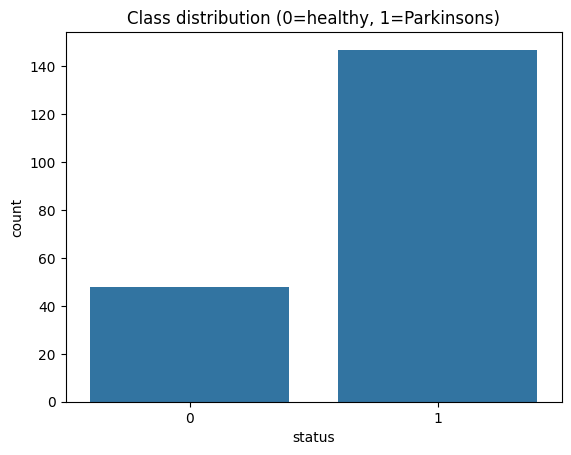

status
1    75.384615
0    24.615385
Name: proportion, dtype: float64


In [9]:
# ===== EDA: class balance =====

sns.countplot(x='status', data=df)
plt.title('Class distribution (0=healthy, 1=Parkinsons)')
plt.show()

print(df['status'].value_counts(normalize=True)*100)

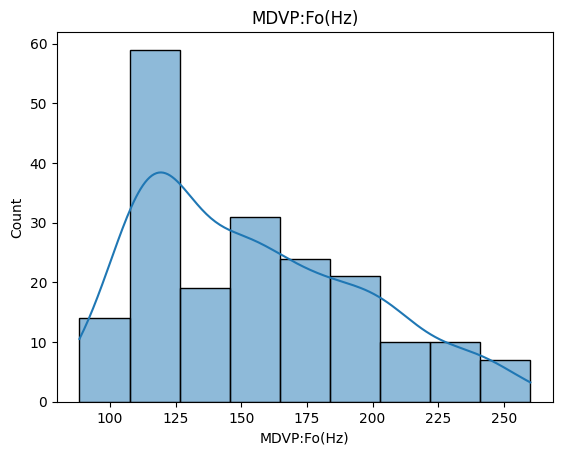

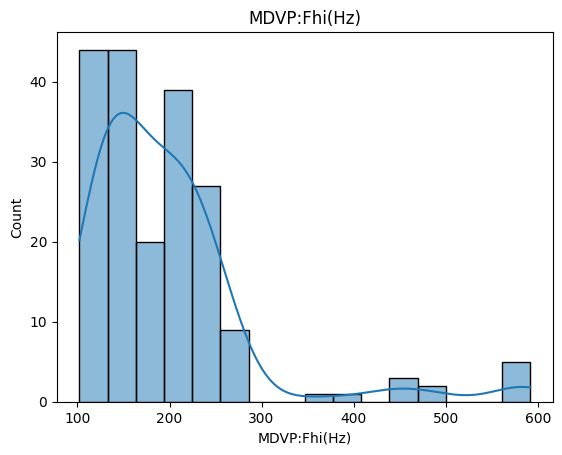

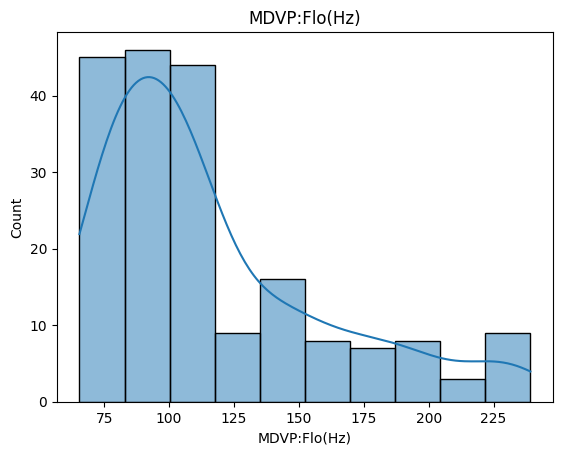

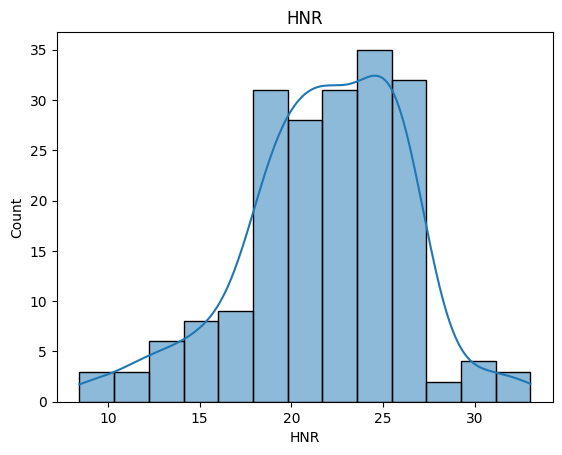

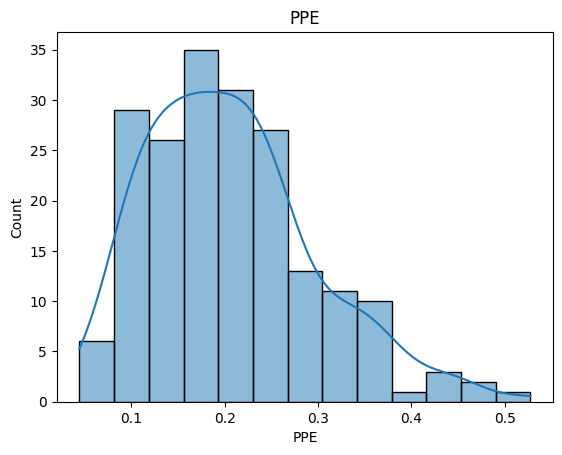

In [10]:
# ===== EDA: feature distributions (a few key ones) =====

features_to_plot = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'HNR', 'PPE']
for col in features_to_plot:
    if col in df.columns:
        plt.figure()
        sns.histplot(df[col], kde=True)
        plt.title(col)
        plt.show()

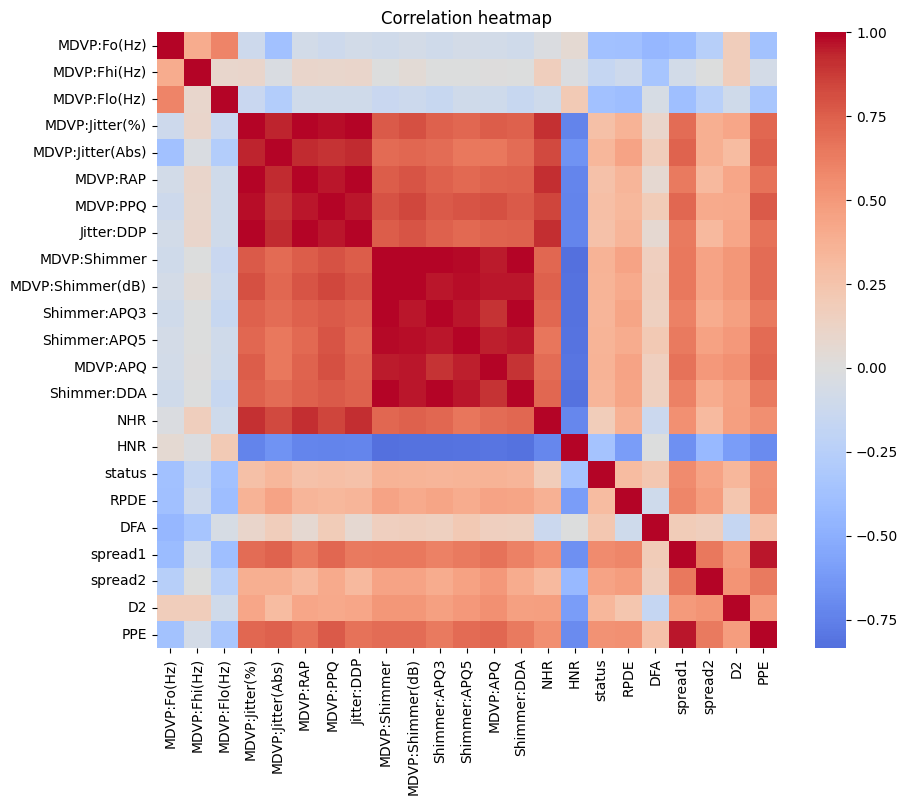

status              1.000000
spread1             0.564838
PPE                 0.531039
spread2             0.454842
MDVP:Shimmer        0.367430
MDVP:APQ            0.364316
Shimmer:APQ5        0.351148
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ3        0.347617
Shimmer:DDA         0.347608
Name: status, dtype: float64


In [11]:
# ===== Correlation heatmap =====

plt.figure(figsize=(10,8))
cor = df.corr()
sns.heatmap(cor, cmap='coolwarm', center=0)
plt.title('Correlation heatmap')
plt.show()

print(cor['status'].sort_values(ascending=False)[:10])

# Normaly after this kind of correlation we do feature engeniring or Pca to have better correlation

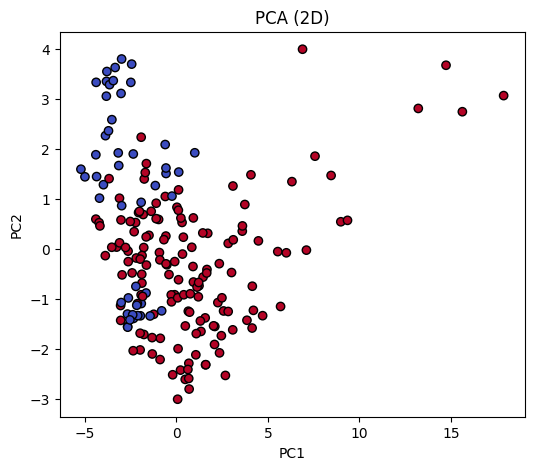

In [12]:
# ===== Simple PCA visualization =====

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_all = df.drop(columns=['status'])
y = df['status']

scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_all)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_all)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', edgecolor='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (2D)')
plt.show()

In [13]:
# ===== Train/Val/Test split (70/15/15) =====

from sklearn.model_selection import train_test_split

X = df.drop(columns=['status'])
y = df['status']

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 15% val, 15% test (split temp in half)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Train: (136, 22) Val: (29, 22) Test: (30, 22)


In [14]:
# ===== Feature scaling (fit on train only) =====

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [15]:
# ===== Class weights for imbalance =====

from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = {c:w for c,w in zip(classes, weights)}
class_weight

{np.int64(0): np.float64(2.0606060606060606),
 np.int64(1): np.float64(0.6601941747572816)}

In [16]:
# ===== Model imports and helper (we will run each model in its own cell) =====

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

# Optional libraries (tree boosters)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed (pip install xgboost to enable it).")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not installed (pip install lightgbm to enable it).")

# Store results for all models here
results = {}


def evaluate_model(name, model, X_tr, y_tr, X_v, y_v):
    """Fit model, compute metrics on validation set, print, and store in results dict."""
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_v)
    y_proba = model.predict_proba(X_v)[:, 1]

    acc = accuracy_score(y_v, y_pred)
    prec = precision_score(y_v, y_pred)
    rec = recall_score(y_v, y_pred)
    f1 = f1_score(y_v, y_pred)
    roc = roc_auc_score(y_v, y_proba)

    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'acc': acc,
        'prec': prec,
        'rec': rec,
        'f1': f1,
        'roc': roc
    }

    print(f"\n=== {name} ===")
    print('Accuracy :', acc)
    print('Precision:', prec)
    print('Recall   :', rec)
    print('F1       :', f1)
    print('ROC-AUC  :', roc)
    print('Confusion matrix:\n', confusion_matrix(y_v, y_pred))

    return model

In [17]:
# ===== Logistic Regression: baseline =====

log_reg = LogisticRegression(max_iter=1000, class_weight=class_weight)
log_reg = evaluate_model('Logistic (baseline)', log_reg,
                         X_train_scaled, y_train,
                         X_val_scaled, y_val)


=== Logistic (baseline) ===
Accuracy : 0.6551724137931034
Precision: 0.9285714285714286
Recall   : 0.5909090909090909
F1       : 0.7222222222222222
ROC-AUC  : 0.9090909090909091
Confusion matrix:
 [[ 6  1]
 [ 9 13]]


In [18]:
# ===== SVM: baseline =====

svm_base = SVC(kernel='rbf', probability=True, class_weight=class_weight, random_state=42)
svm_base = evaluate_model('SVM (baseline)', svm_base,
                          X_train_scaled, y_train,
                          X_val_scaled, y_val)


=== SVM (baseline) ===
Accuracy : 0.7586206896551724
Precision: 0.9411764705882353
Recall   : 0.7272727272727273
F1       : 0.8205128205128205
ROC-AUC  : 0.9090909090909092
Confusion matrix:
 [[ 6  1]
 [ 6 16]]


In [19]:
# ===== Random Forest: baseline =====

rf_base = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight=class_weight
)
rf_base = evaluate_model('RandomForest (baseline)', rf_base,
                         X_train_scaled, y_train,
                         X_val_scaled, y_val)


=== RandomForest (baseline) ===
Accuracy : 0.9310344827586207
Precision: 0.9545454545454546
Recall   : 0.9545454545454546
F1       : 0.9545454545454546
ROC-AUC  : 0.9480519480519481
Confusion matrix:
 [[ 6  1]
 [ 1 21]]


In [20]:
# ===== XGBoost: baseline (if installed) =====

if XGBOOST_AVAILABLE:
    xgb_base = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=class_weight[1] / class_weight[0],
        random_state=42
    )
    xgb_base = evaluate_model('XGBoost (baseline)', xgb_base,
                              X_train_scaled, y_train,
                              X_val_scaled, y_val)
else:
    print('XGBoost not available, skipping XGBoost baseline.')


=== XGBoost (baseline) ===
Accuracy : 0.9310344827586207
Precision: 0.9545454545454546
Recall   : 0.9545454545454546
F1       : 0.9545454545454546
ROC-AUC  : 0.9480519480519481
Confusion matrix:
 [[ 6  1]
 [ 1 21]]


In [21]:
# ===== LightGBM: baseline (if installed) =====

if LIGHTGBM_AVAILABLE:
    lgb_base = lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        class_weight=class_weight,
        random_state=42
    )
    lgb_base = evaluate_model('LightGBM (baseline)', lgb_base,
                              X_train_scaled, y_train,
                              X_val_scaled, y_val)
else:
    print('LightGBM not available, skipping LightGBM baseline.')

[LightGBM] [Info] Number of positive: 103, number of negative: 33
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 136, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [22]:
# ===== MLP Neural Network: baseline =====

mlp_base = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='relu',
    max_iter=1000,
    random_state=42
)
mlp_base = evaluate_model('MLP (baseline)', mlp_base,
                          X_train_scaled, y_train,
                          X_val_scaled, y_val)


=== MLP (baseline) ===
Accuracy : 0.9310344827586207
Precision: 0.9545454545454546
Recall   : 0.9545454545454546
F1       : 0.9545454545454546
ROC-AUC  : 0.9935064935064936
Confusion matrix:
 [[ 6  1]
 [ 1 21]]


In [23]:
# ===== SVM: Bayesian hyperparameter tuning with Optuna (recall-focused) =====

try:
    import optuna
    from sklearn.model_selection import cross_val_score

    def svm_objective(trial):
        C = trial.suggest_float('C', 1e-3, 100.0, log=True)
        gamma = trial.suggest_float('gamma', 1e-4, 1.0, log=True)
        kernel = trial.suggest_categorical('kernel', ['rbf', 'linear'])

        if kernel == 'rbf':
            svm = SVC(
                C=C,
                gamma=gamma,
                kernel='rbf',
                probability=True,
                class_weight=class_weight,
                random_state=42
            )
        else:
            svm = SVC(
                C=C,
                gamma='scale',
                kernel='linear',
                probability=True,
                class_weight=class_weight,
                random_state=42
            )

        scores = cross_val_score(svm, X_train_scaled, y_train,
                                 cv=5, scoring='recall')
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(svm_objective, n_trials=30, show_progress_bar=False)

    print('Best SVM params (Bayesian):', study.best_params)
    print('Best CV recall:', study.best_value)

    best_params = study.best_params
    if best_params['kernel'] == 'rbf':
        svm_best = SVC(
            C=best_params['C'],
            gamma=best_params['gamma'],
            kernel='rbf',
            probability=True,
            class_weight=class_weight,
            random_state=42
        )
    else:
        svm_best = SVC(
            C=best_params['C'],
            gamma='scale',
            kernel='linear',
            probability=True,
            class_weight=class_weight,
            random_state=42
        )

    svm_best = evaluate_model('SVM (Bayesian tuned)', svm_best,
                              X_train_scaled, y_train,
                              X_val_scaled, y_val)

except ImportError:
    print('Optuna not installed (pip install optuna to enable Bayesian search).')

[I 2026-01-29 02:54:19,205] A new study created in memory with name: no-name-4c542833-4ab5-42ff-ba04-e66c8626bd91
[I 2026-01-29 02:54:19,572] Trial 0 finished with value: 0.8623809523809525 and parameters: {'C': 58.111459782297025, 'gamma': 0.00021782744124865117, 'kernel': 'linear'}. Best is trial 0 with value: 0.8623809523809525.
[I 2026-01-29 02:54:19,613] Trial 1 finished with value: 0.7576190476190476 and parameters: {'C': 0.0029627368119765304, 'gamma': 0.019419700921593067, 'kernel': 'linear'}. Best is trial 0 with value: 0.8623809523809525.
[I 2026-01-29 02:54:19,655] Trial 2 finished with value: 0.7371428571428572 and parameters: {'C': 23.43655877846079, 'gamma': 0.000899562050824508, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8623809523809525.
[I 2026-01-29 02:54:19,696] Trial 3 finished with value: 0.8047619047619048 and parameters: {'C': 0.28249745294434775, 'gamma': 0.0020514448128393765, 'kernel': 'linear'}. Best is trial 0 with value: 0.8623809523809525.
[I 2026-01-

Best SVM params (Bayesian): {'C': 5.019986802231066, 'gamma': 0.5806004071367, 'kernel': 'rbf'}
Best CV recall: 1.0

=== SVM (Bayesian tuned) ===
Accuracy : 0.896551724137931
Precision: 0.88
Recall   : 1.0
F1       : 0.9361702127659575
ROC-AUC  : 0.9935064935064936
Confusion matrix:
 [[ 4  3]
 [ 0 22]]


In [24]:
# ===== Random Forest: Bayesian hyperparameter tuning with Optuna (recall-focused) =====

try:
    import optuna
    from sklearn.model_selection import cross_val_score

    def rf_objective(trial):
        # Sample hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 400)
        max_depth = trial.suggest_int('max_depth', 2, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            class_weight=class_weight
        )

        scores = cross_val_score(rf, X_train_scaled, y_train,
                                 cv=5, scoring='recall')
        return scores.mean()

    rf_study = optuna.create_study(direction='maximize')
    rf_study.optimize(rf_objective, n_trials=30, show_progress_bar=False)

    print('Best RandomForest params (Bayesian):', rf_study.best_params)
    print('Best CV recall:', rf_study.best_value)

    rf_best_params = rf_study.best_params
    rf_best = RandomForestClassifier(
        n_estimators=rf_best_params['n_estimators'],
        max_depth=rf_best_params['max_depth'],
        min_samples_split=rf_best_params['min_samples_split'],
        min_samples_leaf=rf_best_params['min_samples_leaf'],
        max_features=rf_best_params['max_features'],
        random_state=42,
        class_weight=class_weight
    )

    rf_best = evaluate_model('RandomForest (Bayesian tuned)', rf_best,
                             X_train_scaled, y_train,
                             X_val_scaled, y_val)

except ImportError:
    print('Optuna not installed (pip install optuna to enable Bayesian search).')

[I 2026-01-29 02:56:46,425] A new study created in memory with name: no-name-777834f1-73e1-4ab5-ba89-b42b862dc953
[I 2026-01-29 02:56:47,866] Trial 0 finished with value: 0.9023809523809524 and parameters: {'n_estimators': 116, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9023809523809524.
[I 2026-01-29 02:56:48,734] Trial 1 finished with value: 0.9123809523809523 and parameters: {'n_estimators': 52, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.9123809523809523.
[I 2026-01-29 02:56:50,311] Trial 2 finished with value: 0.9028571428571428 and parameters: {'n_estimators': 120, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9123809523809523.
[I 2026-01-29 02:56:52,641] Trial 3 finished with value: 0.8923809523809524 and parameters: {'n_estimators': 258, 'max_depth': 5, 'min_sam

Best RandomForest params (Bayesian): {'n_estimators': 185, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best CV recall: 0.9223809523809525

=== RandomForest (Bayesian tuned) ===
Accuracy : 0.8275862068965517
Precision: 0.9473684210526315
Recall   : 0.8181818181818182
F1       : 0.8780487804878049
ROC-AUC  : 0.9350649350649352
Confusion matrix:
 [[ 6  1]
 [ 4 18]]


In [25]:
# ===== Pick best model by Recall and evaluate on test =====

best_name = max(results.keys(), key=lambda n: results[n]['rec'])
best = results[best_name]

print('Best model on validation (by recall):', best_name)

# Evaluate on test
best_model = best['model']
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:,1]

acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc = roc_auc_score(y_test, y_test_proba)

print('\n=== Test set performance of best model ===')
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1:', f1)
print('ROC-AUC:', roc)
print('Confusion matrix:\n', confusion_matrix(y_test, y_test_pred))

Best model on validation (by recall): SVM (Bayesian tuned)

=== Test set performance of best model ===
Accuracy: 0.8333333333333334
Precision: 0.8148148148148148
Recall: 1.0
F1: 0.8979591836734694
ROC-AUC: 0.8522727272727273
Confusion matrix:
 [[ 3  5]
 [ 0 22]]


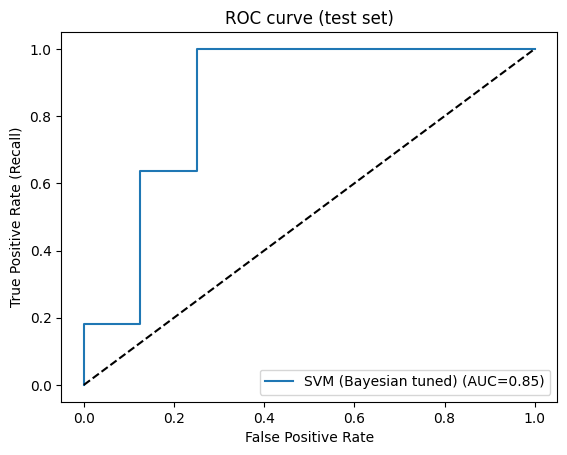

In [26]:
# ===== Simple ROC curve for best model =====

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'{best_name} (AUC={roc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC curve (test set)')
plt.legend()
plt.show()

In [27]:
# ===== Very simple threshold tuning on best model (optional) =====

thresholds = np.linspace(0.2, 0.8, 7)
for t in thresholds:
    y_thr = (y_val_proba := results[best_name]['y_proba']) >= t
    rec = recall_score(y_val, y_thr)
    prec = precision_score(y_val, y_thr)
    print(f'Threshold {t:.2f} -> recall={rec:.3f}, precision={prec:.3f}')

Threshold 0.20 -> recall=1.000, precision=0.880
Threshold 0.30 -> recall=1.000, precision=0.917
Threshold 0.40 -> recall=1.000, precision=0.917
Threshold 0.50 -> recall=1.000, precision=0.917
Threshold 0.60 -> recall=1.000, precision=0.917
Threshold 0.70 -> recall=1.000, precision=0.917
Threshold 0.80 -> recall=1.000, precision=0.957


## Conclusion

- We cleaned the original Parkinson voice dataset (handled missing values, duplicates, removed `name`, ensured labels 0/1).
- We explored the data (class balance, feature distributions, correlations, PCA) and created a 70/15/15 train/validation/test split with proper scaling.
- We trained baseline models: Logistic Regression, SVM, Random Forest, XGBoost (if installed), LightGBM (if installed), and an MLP neural network, all evaluated mainly by **recall**.
- We then applied **Bayesian hyperparameter tuning** (Optuna) to SVM and Random Forest to improve recall.
- The following cells selected the best model by validation recall, evaluated it on the hidden test set, plotted the ROC curve, and tried different thresholds so you can balance recall vs precision.

You can now use this notebook as a full Parkinson detection project: from raw data to tuned models, final test evaluation, and threshold analysis focusing on clinical recall.